This notebook is an abridged version of https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6, with some slight modifications. Done to try out a kaggle competition, plus data preperation and analysis.

# 1. Introduction

This is a 5 Layer Convolutional Neural Network trained on the MNIST dataset.

This notebook is seperated into three parts:
 - Data preparation.
 - The CNN model.
 - The results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools, time

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

/home/glen/.conda/envs/kgl-digitRecogniser/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 2. Data Preparation

## 2.1 Load Data

In [2]:
# Load the data.
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [3]:
# Get the training data labels.
Y_train = train["label"]

# Drop the label from the training data.
X_train = train.drop(labels = ["label"], axis = 1)

# Free up redundant memory.
del train

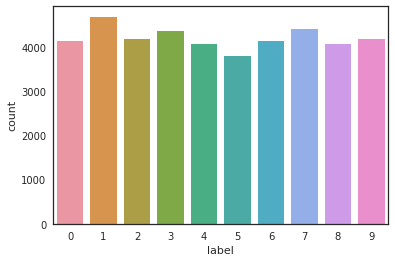

In [4]:
# Plot the distribution of the labels.
g = sns.countplot(Y_train)

## 2.2 Check for Null and Missing Values

In [5]:
# Check the training data for nulls.
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
# Check the test data for nulls.
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## 2.3 Normalization

In [7]:
# Normalise the data.
X_train = X_train / 255.0
test = test / 255.0

## 2.4 Reshape

In [8]:
# Reshape the dataset so it is images in 3 dimensions (single channel)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## 2.5 Label Encoding

In [9]:
# Encode the labels to one-hot vectors.
Y_train = to_categorical(Y_train, num_classes = 10)

## 2.6 Split Training and Validation Set

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

## 2.7 An Example

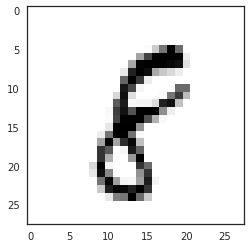

In [11]:
g = plt.imshow(X_train[0][:,:,0], cmap='Greys')

# 3. CNN

## 3.1 Define the Model

In [63]:
# Set the CNN Model.
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size=(5,5), padding="Same", activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters = 32, kernel_size=(5,5), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size=(3,3), padding="Same", activation="relu"))
model.add(Conv2D(filters = 64, kernel_size=(3,3), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 128, kernel_size=(3,3), padding="Same", activation="relu"))
model.add(Conv2D(filters = 128, kernel_size=(3,3), padding="Same", activation="relu"))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation="softmax"))

## 3.2 Set Optimizer and Annealer

In [64]:
# Define the optimizer.
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model.
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [65]:
# Set a learning rate annealer.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [66]:
# Set number of epochs and the batch size.
epochs = 30
batch_size = 128

## 3.3 Data Augmentation

In [67]:
datagen = ImageDataGenerator(
    featurewise_center=False, # Set input mean to 0 over the dataset.
    samplewise_center=False, # Set each sample mean to 0.
    featurewise_std_normalization=False, # Divides inputs by std of the dataset.
    samplewise_std_normalization=False, # Divide each input by its std.
    zca_whitening=False, # Apply ZCA Whitening
    rotation_range=10, # Randomly rotate images in the range of 0 to 180 degrees.
    zoom_range=0.1, # Randomly zoom image.
    width_shift_range=0.1, # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # Randomly shift images vertically (fraction of total height)
    horizontal_flip=False, 
)

datagen.fit(X_train)

## 3.4 Fit Model to Training Data

In [68]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              epochs=epochs, 
                              validation_data=(X_val, Y_val),
                              verbose=2,
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/30
 - 19s - loss: 0.8882 - acc: 0.7004 - val_loss: 0.1226 - val_acc: 0.9676
Epoch 2/30
 - 19s - loss: 0.1653 - acc: 0.9556 - val_loss: 0.0520 - val_acc: 0.9864
Epoch 3/30
 - 18s - loss: 0.1110 - acc: 0.9699 - val_loss: 0.0522 - val_acc: 0.9838
Epoch 4/30
 - 19s - loss: 0.0889 - acc: 0.9760 - val_loss: 0.0519 - val_acc: 0.9881
Epoch 5/30
 - 19s - loss: 0.0804 - acc: 0.9782 - val_loss: 0.0569 - val_acc: 0.9871
Epoch 6/30
 - 18s - loss: 0.0747 - acc: 0.9811 - val_loss: 0.0735 - val_acc: 0.9814
Epoch 7/30
 - 18s - loss: 0.0740 - acc: 0.9807 - val_loss: 0.0342 - val_acc: 0.9924
Epoch 8/30
 - 19s - loss: 0.0675 - acc: 0.9833 - val_loss: 0.0417 - val_acc: 0.9912
Epoch 9/30
 - 19s - loss: 0.0715 - acc: 0.9831 - val_loss: 0.0586 - val_acc: 0.9893
Epoch 10/30
 - 19s - loss: 0.0700 - acc: 0.9836 - val_loss: 0.0470 - val_acc: 0.9898
Epoch 11/30
 - 19s - loss: 0.0708 - acc: 0.9823 - val_loss: 0.0521 - val_acc: 0.9914

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00050000002374

# 4. Evaluate the Model

## 4.1 Training and Validation Curves

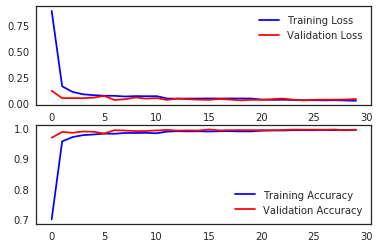

In [76]:
# Plot the loss and accuracy curves for trainign and validation.
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# Plot the loss and accuracy curves for trainign and validation.
ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color='r', label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Because the Validation Accuracy is higher than the Training Accuracy, this model is not subject to overfitting the training data. In fact, the training data is harder to predict due to the data augmentation step.

## 4.2 Confusion Matrix

In [83]:
def plot_confusion_matrix(cm, classes, zero_diagonal=False, normalise=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    The diagonal can be blacked out with `zero_diagonal=True`.
    Normalization can be applied by setting `normalise=True`.
    """
    
    # Make a float copy of the cm for the grid.
    cm_im = np.asarray(cm).astype(float)
    
    if zero_diagonal:
        np.fill_diagonal(cm, 0)
        cm_im[range(cm_im.shape[0]), range(cm_im.shape[1])] = np.nan
        cmap.set_bad((0.85, 0.85, 0.85, 1))
    
    # Display the grid.
    plt.imshow(cm_im, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Display the text on top of the grid.
    if normalise:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if zero_diagonal and i == j :
            continue
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

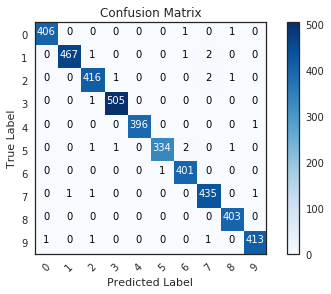

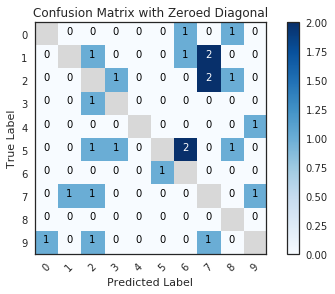

In [84]:
# Predict the values from the validation dataset.
Y_pred = model.predict(X_val)

# Convert predictions classed to one-hot vectors.
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert validation observations to one hot vectors.
Y_true = np.argmax(Y_val, axis=1)

# Compute the confusion matrix.
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix.
plot_confusion_matrix(confusion_mtx, classes=range(10), zero_diagonal=False)
plot_confusion_matrix(confusion_mtx, classes=range(10), 
                      title="Confusion Matrix with Zeroed Diagonal", 
                      zero_diagonal=True)

## 4.3 Error Investigation

In [85]:
# Display some errors.
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

In [86]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 errors with their predicted and real labels. """
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((28, 28)), cmap="Greys")
            ax[row, col].set_title("Predicted label :{}\nTrue label: {}".format(pred_errors[error], obs_errors[error]))
            n += 1

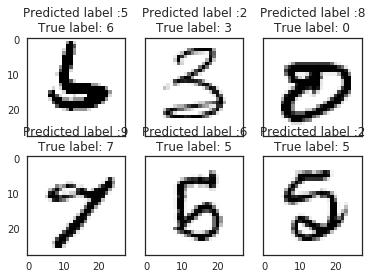

In [87]:
# Probabilities of the wrong predicted numbers.
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

# Predicted probabilities of the true value of the error set.
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label.
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors.
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_delta_errors[-6:]

# Show top 6 errors.
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)


## 4.4 Submission

In [82]:
# Predict results.
results = model.predict(test)

# Select the index with the maximum probability.
results = np.argmax(results, axis=1)

# Save Submission
results = pd.Series(results, name="Label")
submission = pd.concat([pd.Series(range(1, 28001), name="ImageId"), results], axis=1)
submission.to_csv("../results/cnn_mnist_datagen-" + str(int(time.time())) + ".csv", index=False)